In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [165]:
import sys, os
import numpy as np
import xarray as xr

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
import mre_ai.mre_datasets

ModuleNotFoundError: No module named 'medpy'

In [35]:
data_root = '/ocean/projects/asc170022p/shared/Data/MRE/'
%ls $data_root

MRE_DICOM_10-09-19/             XR_with_contrast/
MRE_DICOM_10-22-19/             XR_with_contrast_full_gold/
MRE_DICOM_7-31-19/              XR_with_contrast_full_v2/
MRE_DICOM_9-12-19/              XR_with_contrast_v2/
MRE_DICOM_ORIG/                 data_preprocess_v1.nc*
MRE_dataset_clinical.xlsx*      dicom_scrape_total.p*
XR/                             gold.txt*
XR_full_gold_clinical_v3/       mre_ds_1.p*
XR_full_gold_v3/                mre_ds_preprocess_1.p*
XR_full_gold_v4/                mre_ds_preprocess_2.p*
XR_resized/                     mre_ds_preprocess_3.p*
XR_trimmed/                     mre_ds_preprocess_3_snapmask.p*
XR_trimmed_resized/             mre_ds_preprocess_4_combomask.p*
XR_trimmed_resized_gold/        mre_ds_preprocess_5_pred.p*
XR_trimmed_v2/                  mre_ds_preprocess_5_pred_old.p*
XR_trimmed_v3/                  mre_ds_preprocess_5_pred_v2.p*
XR_trimmed_with_contrast/       mre_ds_preprocess_5_pred_v3.p*
XR_trimmed_with_contrast_gold/  mre_ds_p

In [39]:
%ls $data_root/MRE_DICOM_* -d

/ocean/projects/asc170022p/shared/Data/MRE//MRE_DICOM_10-09-19/
/ocean/projects/asc170022p/shared/Data/MRE//MRE_DICOM_10-22-19/
/ocean/projects/asc170022p/shared/Data/MRE//MRE_DICOM_7-31-19/
/ocean/projects/asc170022p/shared/Data/MRE//MRE_DICOM_9-12-19/
/ocean/projects/asc170022p/shared/Data/MRE//MRE_DICOM_ORIG/


In [40]:
%ls $data_root/MRE_DICOM_ORIG

148_bad/   195/      264/  299/      350_bad2/  361/      372/  388/      403/
162/       197/      280/  302/      351/       363/      375/  391/      404/
163/       218/      289/  331/      354/       365/      380/  394/      405/
178_bad/   220/      292/  332/      357/       368/      381/  396_bad/  406/
178_bad2/  222/      295/  343/      358/       370/      383/  399/
189/       239_bad/  296/  350_bad/  360/       371_bad/  386/  402/


In [44]:
%ls $data_root/MRE_DICOM_ORIG/ | wc -l

52


In [41]:
%ls $data_root/MRE_DICOM_ORIG/148_bad

DICOM/      T1Pre.nii*  T2SS.nii*   elastMsk.nii*
T1Pos.nii*  T2FR.nii*   elast.nii*  seg.nii*


In [47]:
%ls $data_root/MRE_DICOM_ORIG/148_bad/DICOM/ST00001

SE00001/  SE00002/  SE00003/  SE00004/  SE00005/  SE00006/


In [48]:
%ls $data_root/MRE_DICOM_ORIG/148_bad/DICOM/ST00001/SE00001/

IM00001*  IM00002*  IM00003*  IM00004*


In [42]:
%ls $data_root/MRE_DICOM_ORIG/162

DICOM/         model_2019-05-13_12-34-04.pkl*  model_2019-05-13_14-53-50.pkl*
T1Pos.nii*     model_2019-05-13_12-39-26.pkl*  model_2019-05-16_13-11-30.pkl*
T1Pre.nii*     model_2019-05-13_12-41-50.pkl*  model_2019-05-19_16-20-46.pkl*
T2FR.nii*      model_2019-05-13_12-47-53.pkl*  model_2019-05-21_14-17-38.pkl*
T2SS.nii*      model_2019-05-13_13-53-29.pkl*  seg.nii*
elast.nii*     model_2019-05-13_13-57-49.pkl*
elastMsk.nii*  model_2019-05-13_14-01-26.pkl*


In [45]:
%ls $data_root/MRE_DICOM_ORIG/162/DICOM

ST00001/


In [29]:
%ls $data_root/MRE_DICOM_7-31-19

DICOM/   DICOMC/    DICOMDIR.OLD*  DICOMG/        xarray_test.nc*
DICOMA/  DICOMD/    DICOME/        DIR_INFO.TXT*
DICOMB/  DICOMDIR*  DICOMF/        NIFTI/


In [50]:
%ls $data_root/MRE_DICOM_7-31-19/NIFTI

 0006/   0029/   0123/   0175/   0362/   0450/   2033/       'CASE 2^2'/
 001/    0041/   0126/   0189/   0378/   1753/   2036/
 0014/   0043/   0135/   0199/   0384/   2007/   2040/
 0015/   0047/   0155/   0213/   0395/   2012/   2050/
 0020/   0079/   0164/   0291/   0401/   2013/   2052/
 0021/   0084/   0167/   0314/   0415/   2015/   2053/
 0024/   0094/   0172/   0332/   0424/   2029/   2060/
 0026/   0096/   0173/   0344/   0435/   2032/  'CASE 1^1'/


In [51]:
%ls $data_root/MRE_DICOM_7-31-19/NIFTI | wc -l

57


In [ ]:
%ls $data_root/MRE_DICOM_7-31-19/NIFTI/001/

In [54]:
%ls $data_root/MRE_DICOM_7-31-19/NIFTI/0014/

MRE_DICOM_7-31-19_DICOME_PA6*  t1_pos_0_water.nii*    t1_pos_70_in.nii*
dwi.nii*                       t1_pos_160_fat.nii*    t1_pos_70_out.nii*
mre.nii*                       t1_pos_160_in.nii*     t1_pos_70_water.nii*
mre.pkl*                       t1_pos_160_out.nii*    t1_pre_fat.nii*
mre_mask.nii*                  t1_pos_160_water.nii*  t1_pre_in.nii*
mre_raw.nii*                   t1_pos_300_fat.nii*    t1_pre_out.nii*
mre_wave.nii*                  t1_pos_300_in.nii*     t1_pre_water.nii*
t1_pos_0_fat.nii*              t1_pos_300_out.nii*    wave.nii*
t1_pos_0_in.nii*               t1_pos_300_water.nii*
t1_pos_0_out.nii*              t1_pos_70_fat.nii*


In [55]:
%ls $data_root/MRE_DICOM_9-12-19/

DICOMH/  DICOMI/  DICOMJ/  DICOMK/  DICOML/  DICOMM/  DICOMN/  DICOMO/  NIFTI/


In [56]:
%ls $data_root/MRE_DICOM_9-12-19/NIFTI/

0210/  0457/  0525/  0648/  0717/  1699/  1765/  1818/  1853/  1930/  1983/
0213/  0461/  0556/  0649/  0727/  1706/  1783/  1819/  1855/  1932/  1987/
0219/  0488/  0564/  0650/  0734/  1712/  1785/  1821/  1857/  1935/  1990/
0221/  0490/  0577/  0653/  0735/  1714/  1786/  1828/  1867/  1939/  1994/
0222/  0491/  0598/  0655/  0737/  1715/  1789/  1829/  1883/  1940/  2001/
0224/  0492/  0604/  0659/  0740/  1720/  1790/  1834/  1889/  1946/  2034/
0234/  0496/  0612/  0668/  0747/  1722/  1791/  1837/  1893/  1948/  2046/
0235/  0501/  0615/  0673/  0748/  1727/  1793/  1839/  1896/  1964/
0245/  0502/  0618/  0684/  0770/  1731/  1795/  1841/  1899/  1967/
0250/  0509/  0625/  0690/  1671/  1736/  1798/  1843/  1903/  1970/
0440/  0510/  0628/  0693/  1679/  1741/  1806/  1844/  1915/  1971/
0453/  0515/  0632/  0698/  1682/  1748/  1807/  1850/  1917/  1979/
0455/  0516/  0639/  0704/  1694/  1749/  1811/  1851/  1927/  1980/


In [58]:
%ls $data_root/MRE_DICOM_9-12-19/NIFTI/ | wc -l

137


In [59]:
%ls $data_root/MRE_DICOM_9-12-19/NIFTI/0210/

MRE_DICOM_9-12-19_DICOMH_PA4*  t1_pos_0_fat.nii*      t1_pos_70_water.nii*
dwi.nii*                       t1_pos_0_water.nii*    t1_pre_fat.nii*
mre.nii*                       t1_pos_160_fat.nii*    t1_pre_in.nii*
mre.pkl*                       t1_pos_160_water.nii*  t1_pre_out.nii*
mre_mask.nii*                  t1_pos_300_fat.nii*    t1_pre_water.nii*
mre_raw.nii*                   t1_pos_300_water.nii*  t2.nii*
mre_wave.nii*                  t1_pos_70_fat.nii*     wave.nii*


In [60]:
%ls $data_root/MRE_DICOM_10-09-19/

DICOM/  DICOMA/  DICOMB/  DICOMC/  DICOMD/  DICOME/  DICOMF/  DICOMG/  NIFTI/


In [61]:
%ls $data_root/MRE_DICOM_10-09-19/NIFTI/

0822/  0900/  0964/  1033/  1095/  1149/  1209/  1271/  1474/  1529/  1579/
0830/  0903/  0965/  1039/  1103/  1155/  1214/  1274/  1479/  1530/  1586/
0838/  0904/  0972/  1045/  1105/  1156/  1215/  1278/  1481/  1541/  1590/
0846/  0910/  0975/  1053/  1106/  1158/  1217/  1284/  1483/  1545/  1595/
0850/  0914/  0978/  1072/  1108/  1171/  1219/  1287/  1490/  1550/  1598/
0854/  0917/  0979/  1075/  1110/  1181/  1231/  1290/  1491/  1551/  1603/
0859/  0924/  0989/  1076/  1119/  1187/  1239/  1292/  1495/  1554/  1604/
0860/  0929/  0995/  1077/  1121/  1189/  1250/  1296/  1504/  1560/  1612/
0872/  0931/  0997/  1081/  1123/  1192/  1254/  1302/  1514/  1561/  1642/
0890/  0932/  1001/  1082/  1134/  1193/  1257/  1303/  1515/  1562/  1667/
0892/  0937/  1002/  1083/  1138/  1199/  1261/  1311/  1519/  1574/
0894/  0940/  1028/  1090/  1140/  1205/  1262/  1318/  1523/  1577/
0898/  0954/  1030/  1092/  1144/  1207/  1266/  1322/  1526/  1578/


In [62]:
%ls $data_root/MRE_DICOM_10-09-19/NIFTI/ | wc -l

140


In [63]:
%ls $data_root/MRE_DICOM_10-09-19/NIFTI/0822

MRE_DICOM_10-09-19_DICOM_PA8*  t1_pre_fat.nii*  t1_pre_out.nii*
t1_pos_0_water.nii*            t1_pre_in.nii*   t1_pre_water.nii*


In [65]:
%ls $data_root/MRE_DICOM_10-22-19/

DICOM/  DICOMA/  NIFTI/


In [66]:
%ls $data_root/MRE_DICOM_10-22-19/NIFTI/

1230/  1336/  1343/  1356/  1373/  1404/  1417/  1427/  1447/  1456/  1473/
1322/  1337/  1344/  1360/  1382/  1406/  1423/  1433/  1448/  1459/
1328/  1341/  1346/  1362/  1395/  1412/  1425/  1435/  1451/  1460/
1329/  1342/  1350/  1367/  1400/  1415/  1426/  1440/  1453/  1464/


In [67]:
%ls $data_root/MRE_DICOM_10-22-19/NIFTI/ | wc -l

41


In [68]:
%ls $data_root/MRE_DICOM_10-22-19/NIFTI/1230/

MRE_DICOM_10-22-19_DICOM_PA25*  t1_pos_0_fat.nii*      t1_pos_70_water.nii*
dwi.nii*                        t1_pos_0_water.nii*    t1_pre_fat.nii*
mre.nii*                        t1_pos_160_fat.nii*    t1_pre_in.nii*
mre.pkl*                        t1_pos_160_water.nii*  t1_pre_out.nii*
mre_mask.nii*                   t1_pos_300_fat.nii*    t1_pre_water.nii*
mre_raw.nii*                    t1_pos_300_water.nii*  t2.nii*
mre_wave.nii*                   t1_pos_70_fat.nii*     wave.nii*


In [73]:
nifti_dirs = [
    'MRE_DICOM_7-31-19',
    'MRE_DICOM_9-12-19',
    'MRE_DICOM_10-09-19',
    'MRE_DICOM_10-22-19'
]

sequences = [
    'dwi',
    'mre',
    'mre_mask',
    'mre_raw',
    'mre_wave',
    'mre_phase',
    't1_pos_0_fat',
    't1_pos_0_in',
    't1_pos_0_out',
    't1_pos_0_water',
    't1_pos_160_fat',
    't1_pos_160_in',
    't1_pos_160_out',
    't1_pos_160_water',
    't1_pos_300_fat',
    't1_pos_300_in',
    't1_pos_300_out',
    't1_pos_300_water',
    't1_pos_70_fat',
    't1_pos_70_in',
    't1_pos_70_out',
    't1_pos_70_water',
    't1_pre_fat',
    't1_pre_in',
    't1_pre_out',
    't1_pre_water',
    't2',
    'wave'
]

for nifti_dir in nifti_dirs:
    nifti_dir = os.path.join(data_root, nifti_dir, 'NIFTI')
    for patient_id in sorted(os.listdir(nifti_dir)):
        for sequence in sequences:
            print()

MRE_DICOM_7-31-19 0006
MRE_DICOM_7-31-19 001
MRE_DICOM_7-31-19 0014
MRE_DICOM_7-31-19 0015
MRE_DICOM_7-31-19 0020
MRE_DICOM_7-31-19 0021
MRE_DICOM_7-31-19 0024
MRE_DICOM_7-31-19 0026
MRE_DICOM_7-31-19 0029
MRE_DICOM_7-31-19 0041
MRE_DICOM_7-31-19 0043
MRE_DICOM_7-31-19 0047
MRE_DICOM_7-31-19 0079
MRE_DICOM_7-31-19 0084
MRE_DICOM_7-31-19 0094
MRE_DICOM_7-31-19 0096
MRE_DICOM_7-31-19 0123
MRE_DICOM_7-31-19 0126
MRE_DICOM_7-31-19 0135
MRE_DICOM_7-31-19 0155
MRE_DICOM_7-31-19 0164
MRE_DICOM_7-31-19 0167
MRE_DICOM_7-31-19 0172
MRE_DICOM_7-31-19 0173
MRE_DICOM_7-31-19 0175
MRE_DICOM_7-31-19 0189
MRE_DICOM_7-31-19 0199
MRE_DICOM_7-31-19 0213
MRE_DICOM_7-31-19 0291
MRE_DICOM_7-31-19 0314
MRE_DICOM_7-31-19 0332
MRE_DICOM_7-31-19 0344
MRE_DICOM_7-31-19 0362
MRE_DICOM_7-31-19 0378
MRE_DICOM_7-31-19 0384
MRE_DICOM_7-31-19 0395
MRE_DICOM_7-31-19 0401
MRE_DICOM_7-31-19 0415
MRE_DICOM_7-31-19 0424
MRE_DICOM_7-31-19 0435
MRE_DICOM_7-31-19 0450
MRE_DICOM_7-31-19 1753
MRE_DICOM_7-31-19 2007
MRE_DICOM_7-

In [163]:
import SimpleITK as sitk

def load_nifti_file(nii_file):
    
    print(f'Loading {nii_file}')
    im = sitk.ReadImage(nii_file)
    
    dtype = im.GetPixelIDTypeAsString()
    ndim = im.GetDimension()
    shape = im.GetSize()
    origin = im.GetOrigin()
    resolution = im.GetSpacing()
    n_components = im.GetNumberOfComponentsPerPixel()
    
    print(f'dtype = {dtype}')
    print(f'ndim = {ndim}')
    print(f'shape = {shape}')
    print(f'origin = {origin}')
    print(f'resolution = {resolution}')
    print(f'n_components = {n_components}')
    
    if ndim == 3:
        dims = ['x', 'y', 'z']
    elif ndim == 2:
        dims = ['x', 'y']

    coords = {}
    for i, dim in enumerate(dims):
        coords[dim] = origin[i] + np.arange(shape[i]) * resolution[i]

    if n_components > 1:
        dims.append('component')
        coords['component'] = np.arange(n_components)
        a = sitk.GetArrayFromImage(im)
        axes = (2, 1, 0, 3)
        a = np.transpose(a, axes)
    else:
        a = sitk.GetArrayFromImage(im).T
    print(a.shape, a.dtype)
    return xr.DataArray(a, dims=dims, coords=coords)

nii_file = os.path.join(data_root, 'MRE_DICOM_7-31-19', 'NIFTI', '0006', 't1_pos_300_water.nii')
a = load_nifti_file(nii_file)
a

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pos_300_water.nii
dtype = 16-bit signed integer
ndim = 3
shape = (512, 512, 88)
origin = (-204.1300048828125, -208.5919952392578, -142.01300048828125)
resolution = (0.7031000256538391, 0.7031000256538391, 2.3000030517578125)
n_components = 1
(512, 512, 88) int16


<xarray.DataArray (x: 512, y: 512, z: 88)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
  * x        (x) float64 -204.1 -203.4 -202.7 -202.0 ... 153.0 153.7 154.5 155.2
  * y        (y) float64 -208.6 -207.9 -207.2 -206.5 ... 148.6 149.3 150.0 150.7
  * z        (z) float64 -142.0 -139.7 -137.4 -135.1 ... 51.19 53.49 55.79 58.09

<IPython.core.display.Javascript object>


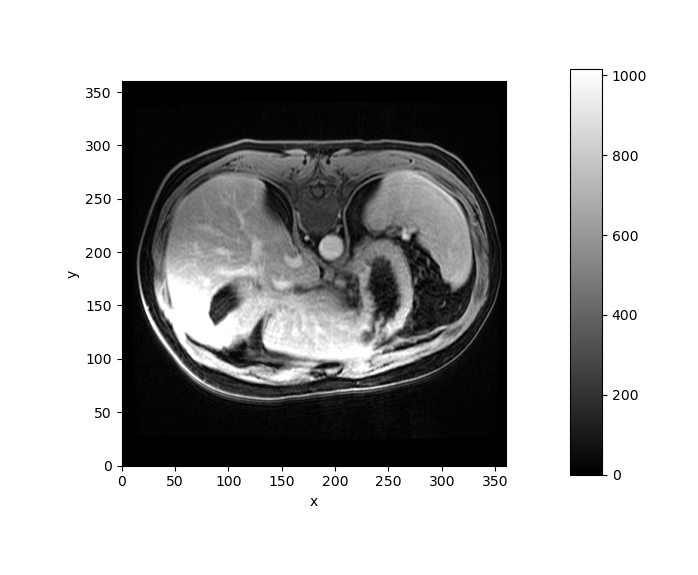

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [164]:
mre_pinn.visual.XArrayViewer(a, ax_height=3, cmap=mre_pinn.visual.grayscale_color_map())